In [1]:
import numpy as np
import pandas as pd
import torch
import torchaudio
import torchaudio.transforms as T
import torch.nn.functional as F
from torch.utils.data import Dataset
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fftpack import fft
from scipy import signal
import IPython.display as ipd
from tqdm.notebook import tqdm

from Project_2.src.utils.DataHelper import SpeechCommandsDataset 

def read_list(file_path):
    with open(file_path, 'r') as f:        return set(line.strip() for line in f.readlines())

# Load Sample Data

In [2]:
data_dir='Project_2/data/train'

data_dir = Path(data_dir).resolve()

# Read which files belong to which set
val_list = read_list(data_dir / 'validation_list.txt')
test_list = read_list(data_dir / 'testing_list.txt')

# Create a dictionary to hold the file paths for each set
dataset_path = data_dir / 'audio'
all_data = {'training': [], 'validation': [], 'testing': []}

# Check if the directory exists
if not dataset_path.exists():
    raise FileNotFoundError(f"Dataset path does not exist: {dataset_path}")

# Print dataset_path for debugging
print(f"Looking for audio files in: {dataset_path}")

for audio_path in dataset_path.rglob("*.wav"):
    relative_path = audio_path.relative_to(dataset_path).as_posix()

    if relative_path in val_list:
        all_data['validation'].append(audio_path)
    elif relative_path in test_list:
        all_data['testing'].append(audio_path)
    else:
        all_data['training'].append(audio_path)

train_dataset = SpeechCommandsDataset(all_data['training'])

Looking for audio files in: D:\Studia - Pobrane Wyklady\MINI\Semestr 8\Deep_Learning_Projects\Project_2\data\train\audio


Waveform shape: torch.Size([1, 16000]), Sample rate: 16000, Label: bed


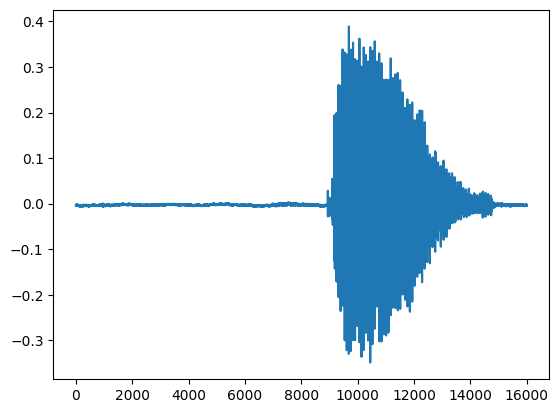

In [3]:
waveform, label, sample_rate = train_dataset[1]
print(f"Waveform shape: {waveform.shape}, Sample rate: {sample_rate}, Label: {label}")
plt.plot(waveform.t().numpy())

In [4]:
ipd.Audio(waveform.numpy(), rate=sample_rate)

In [5]:
waveform.max(), waveform.min(), waveform.mean(), waveform.std()

(tensor(0.3888), tensor(-0.3485), tensor(-0.0029), tensor(0.0373))

# Understanding Waveform Values

The `waveform` variable contains a representation of the audio signal as a time series of amplitude values. Let's break down what these values mean:

## What is a Waveform?
- A waveform is a visual representation of sound as it travels through air as pressure waves
- In digital form, it's represented as a sequence of amplitude values measured at regular time intervals
- Our waveform has shape: `torch.Size([1, x])` where:
  - 1 = Number of channels (mono audio)
  - x = Number of samples (time steps)

## Waveform Values Explained
- The values in our tensor represent the **amplitude** (air pressure deviation) at each point in time
- Values are typically normalized between -1.0 and 1.0 (though our values are much smaller)
- Positive values represent compression (higher pressure)
- Negative values represent rarefaction (lower pressure)
- Zero represents atmospheric pressure (silence/no deviation)

## Statistical Properties
- Looking at the statistics we just printed:
  - Maximum value: How loud the loudest part of the audio is
  - Minimum value: The most negative pressure deviation
  - Mean: Should be close to zero for properly centered audio
  - Standard deviation: Indicates the dynamic range/average loudness

## Key Characteristics of Speech Waveforms
- **Frequency**: How many cycles per second (Hz) - determines pitch
- **Amplitude**: Height of the wave - determines volume
- **Phase**: Where in the cycle the wave begins
- **Timbre**: The quality that makes different sound sources sound different even at the same pitch and volume (complex combination of harmonics)

This digital representation of sound is what our neural networks will use to learn patterns associated with different speech commands.

Duration: 1.00 seconds
Number of samples: 16000
Dynamic range: 0.737335
RMS value (loudness measure): 0.037371


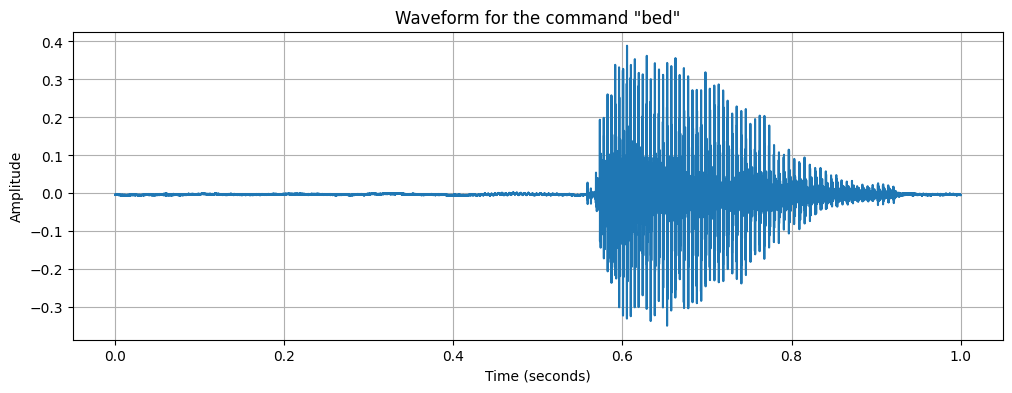

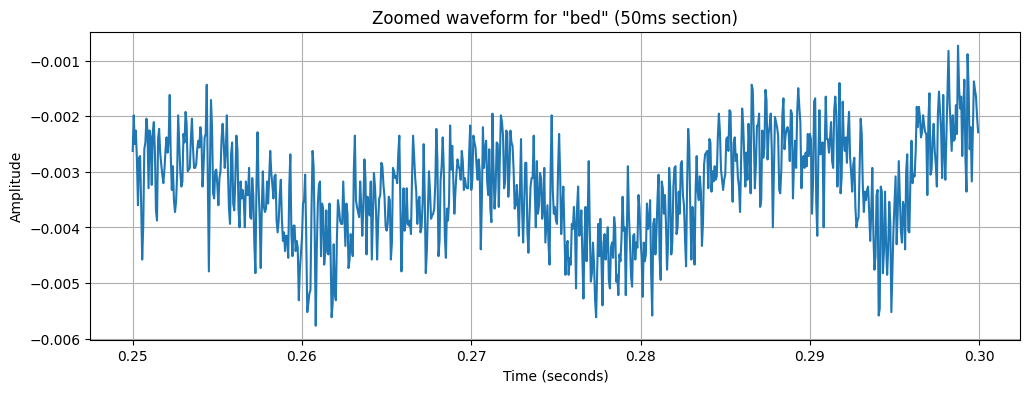

In [6]:
# Let's visualize the waveform in more detail
plt.figure(figsize=(12, 4))
time_axis = torch.arange(0, waveform.shape[1]) / sample_rate
plt.plot(time_axis, waveform[0])
plt.title(f'Waveform for the command "{label}"')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)

# Zoom in to see the detailed pattern
plt.figure(figsize=(12, 4))
zoom_start = int(waveform.shape[1] * 0.25)  # look at a section 25% in
zoom_length = int(sample_rate * 0.05)  # look at 50ms
zoom_end = zoom_start + zoom_length
plt.plot(time_axis[zoom_start:zoom_end], waveform[0, zoom_start:zoom_end])
plt.title(f'Zoomed waveform for "{label}" (50ms section)')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)

# Let's compute some additional properties
print(f"Duration: {waveform.shape[1]/sample_rate:.2f} seconds")
print(f"Number of samples: {waveform.shape[1]}")
print(f"Dynamic range: {waveform.max() - waveform.min():.6f}")
print(f"RMS value (loudness measure): {torch.sqrt(torch.mean(waveform**2)):.6f}")

Text(0.5, 0, 'Seconds')

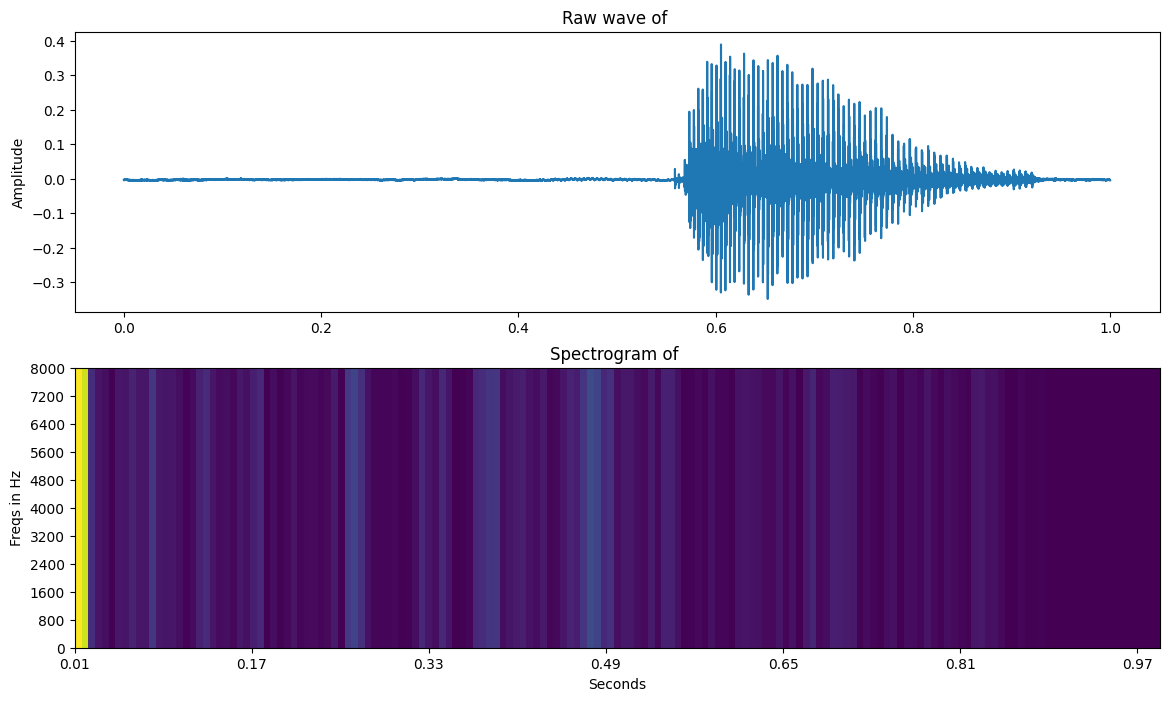

In [7]:
# https://www.kaggle.com/code/davids1992/speech-representation-and-data-exploration

def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

freqs, times, spectrogram = log_specgram(waveform, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, len(waveform[0]) / sample_rate, len(waveform[0])), waveform[0])

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram[0].T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

# Understanding Spectrograms

## What is a Spectrogram?

A spectrogram is a visual representation of the spectrum of frequencies in a sound as they vary with time. It's essentially a **time-frequency representation** that shows how the energy of the sound signal is distributed across different frequencies over time.

## How is a Spectrogram Created?

1. **Short-Time Fourier Transform (STFT)**: 
   - The audio waveform is divided into short, overlapping segments
   - For each segment, a Fourier transform is applied to convert the time-domain signal to a frequency-domain representation
   - This gives us the frequency content for each short time window

2. **Key Parameters in Spectrogram Generation**:
   - **Window Size**: The duration of each segment (in our code: `window_size=20ms`)
   - **Step Size**: How much to move forward for the next segment (in our code: `step_size=10ms`)
   - **Window Function**: Applied to each segment to reduce spectral leakage (we use 'hann' window)

3. **Logarithmic Scale**:
   - We typically use a logarithmic scale for the magnitude (power) to better match human hearing perception
   - This is why we apply `np.log()` to the spectrogram values

## Reading a Spectrogram

In the spectrogram plot above:
- **X-axis**: Time (in seconds)
- **Y-axis**: Frequency (in Hz)
- **Color intensity**: Energy/power at each time-frequency point (brighter = higher energy)

## Why Spectrograms are Important for Speech Recognition

1. **Rich Feature Representation**:
   - Spectrograms capture both time and frequency information simultaneously
   - They preserve the temporal dynamics of speech while showing frequency patterns

2. **Speech Characteristics in Spectrograms**:
   - **Formants**: Appear as bright horizontal bands - these are resonant frequencies of the vocal tract
   - **Consonants**: Often appear as vertical lines or brief bursts of energy across frequencies
   - **Vowels**: Show up as sustained horizontal bands at specific frequencies
   - **Pitch**: For voiced sounds, you can see the fundamental frequency (F0) and its harmonics

3. **Neural Network Input**:
   - CNNs can effectively process spectrograms as 2D images
   - Local patterns in frequency and time can be detected with convolutional filters
   - This makes spectrograms an ideal representation for deep learning-based audio classification

## Spectrogram Variants

- **Mel Spectrogram**: Converts the frequency scale to the Mel scale, which better matches human auditory perception
- **MFCC (Mel-Frequency Cepstral Coefficients)**: A compact representation derived from the Mel spectrogram
- **Constant-Q Transform**: Uses logarithmically spaced frequency bins, providing better resolution for lower frequencies

The spectrogram representation transforms our 1D waveform into a 2D time-frequency map that captures the rich harmonic structure of speech, making it much easier for neural networks to recognize patterns associated with different speech commands.

Regular Spectrogram Shape: (99, 161, 1)
Mel Spectrogram Shape: torch.Size([1, 64, 32])

Mel spectrograms use fewer frequency bands (64 vs. many more in regular spectrograms)
and distribute them according to how humans perceive pitch differences.


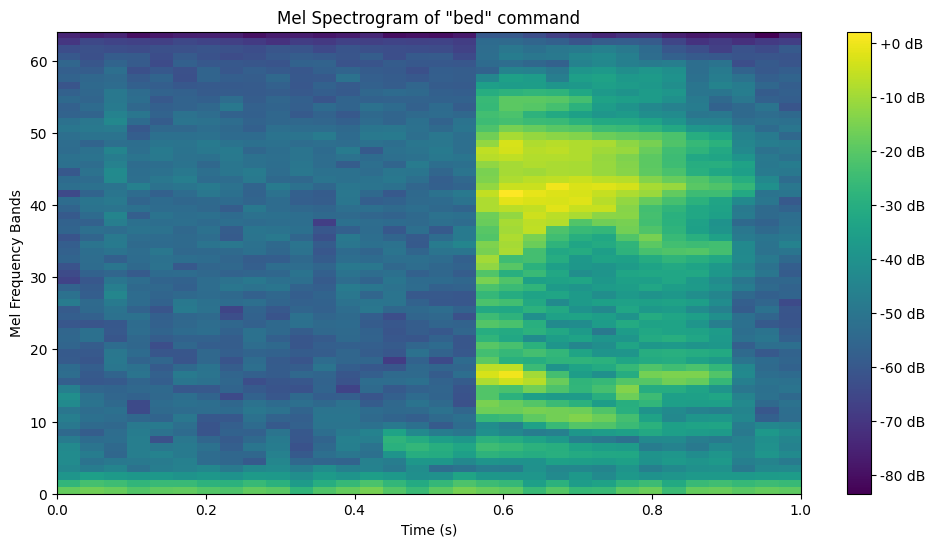

In [8]:
# Let's create a Mel Spectrogram, which is often better for speech recognition
n_fft = 1024
win_length = 400
hop_length = 512
n_mels = 64

# Create transform
mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    n_mels=n_mels,
    mel_scale="htk",
)

# Get mel spectrogram
mel_spec = mel_spectrogram(waveform)

# Convert to decibels
mel_spec_db = T.AmplitudeToDB()(mel_spec)

# Plot the mel spectrogram
plt.figure(figsize=(12, 6))
plt.imshow(mel_spec_db[0].numpy(), aspect='auto', origin='lower', 
           extent=[0, waveform.shape[1]/sample_rate, 0, n_mels])
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel Spectrogram of "{label}" command')
plt.ylabel('Mel Frequency Bands')
plt.xlabel('Time (s)')

# Show differences between regular and mel spectrograms
print("Regular Spectrogram Shape:", spectrogram.shape)
print("Mel Spectrogram Shape:", mel_spec_db.shape)
print("\nMel spectrograms use fewer frequency bands (64 vs. many more in regular spectrograms)")
print("and distribute them according to how humans perceive pitch differences.")

# Building a Neural Network for Speech Command Recognition

Now we'll build a neural network model to classify speech commands. We'll use the following approach:

1. **Data Preparation**: Convert audio waveforms to Mel Spectrograms
2. **Model Architecture**: Use a Convolutional Neural Network (CNN) architecture
3. **Training**: Train the model using cross-entropy loss and track accuracy
4. **Evaluation**: Evaluate on a validation set

Let's start by creating a custom dataset that converts our audio to Mel Spectrograms.

In [12]:
# Define a class to convert waveforms to Mel Spectrograms
class SpeechCommandsSpectrogramDataset(Dataset):
    def __init__(self, file_list, n_mels=64, n_fft=1024, hop_length=512, standardize=False):
        self.file_list = file_list
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.standardize = standardize
        
        # Create the Mel spectrogram transform
        self.mel_transform = T.MelSpectrogram(
            sample_rate=16000,  # Default sample rate for this dataset
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels,
            power=2.0,
        )
        
        # Create a decibel converter
        self.amp_to_db = T.AmplitudeToDB()
        
        # Get unique label names and create a mapping to indices
        self.labels = sorted(list(set(path.parent.name for path in file_list)))
        self.label_to_index = {label: i for i, label in enumerate(self.labels)}
        
        # If standardization is enabled, compute dataset statistics
        if self.standardize:
            self.compute_stats()
        
        print(f"Found {len(self.labels)} unique classes: {self.labels}")
        
    def compute_stats(self, sample_size=500):
        """Compute mean and std of mel spectrograms for standardization"""
        print(f"Computing dataset statistics on {min(sample_size, len(self.file_list))} samples...")
        # Take a subset of files to compute stats (for efficiency)
        import random
        sample_files = random.sample(self.file_list, min(sample_size, len(self.file_list)))
        
        # Collect all spectrogram values
        all_values = []
        for file_path in sample_files:
            waveform, sample_rate = torchaudio.load(str(file_path))
            mel_spec = self.mel_transform(waveform)
            mel_spec_db = self.amp_to_db(mel_spec)
            all_values.append(mel_spec_db.reshape(-1))  # Flatten the spectrogram
            
        # Concatenate all values and compute statistics
        import numpy as np
        all_values = np.concatenate(all_values)
        self.spec_mean = float(np.mean(all_values))
        self.spec_std = float(np.std(all_values))
        print(f"Dataset statistics - Mean: {self.spec_mean:.2f}, Std: {self.spec_std:.2f}")
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        # print(f"Loading file {idx+1}/{len(self.file_list)}: {self.file_list[idx]}")
        path = self.file_list[idx]
        # Load the waveform
        waveform, sample_rate = torchaudio.load(str(path))
        
        # Convert to Mel spectrogram
        mel_spec = self.mel_transform(waveform)
        # Convert to decibels (log scale) - this helps the model learn better
        mel_spec_db = self.amp_to_db(mel_spec)
        
        # Standardize if enabled
        if self.standardize:
            mel_spec_db = (mel_spec_db - self.spec_mean) / self.spec_std
        
        # Get the label
        label = path.parent.name
        label_idx = self.label_to_index[label]
        
        return mel_spec_db, label_idx, label
    
    @property
    def num_classes(self):
        return len(self.labels)

## Benefits of Standardizing Mel Spectrograms

Standardizing the mel spectrogram values (subtracting mean and dividing by standard deviation) offers several advantages:

1. **Improved Training Stability**: Neural networks generally train better with normalized inputs, as this helps with gradient flow and prevents saturation of activation functions.

2. **Faster Convergence**: Standardized inputs typically lead to faster convergence during training because the optimizer doesn't need to compensate for features with different scales.

3. **Volume Invariance**: Standardization helps make the model more invariant to different recording volumes, as it normalizes the intensity of the spectrograms.

4. **Better Generalization**: Models trained on standardized inputs can generalize better to new data with different recording conditions.

The implementation above computes dataset statistics on a random sample of the training data, which is an efficient approach for large datasets. For production systems, you might want to precompute these statistics on the entire dataset or use a larger sample size.

In [13]:
train_spectrogram_dataset = SpeechCommandsSpectrogramDataset(all_data['training'], standardize=False)
val_spectrogram_dataset = SpeechCommandsSpectrogramDataset(all_data['validation'], standardize=False)
test_spectrogram_dataset = SpeechCommandsSpectrogramDataset(all_data['testing'], standardize=False)


# Function for padding spectrograms in a batch (they might have different lengths)
def collate_spectrograms(batch):
    # Unpack all 4 values but only use the first 3
    specs, label_ids, labels = zip(*batch)
    
    # Find max width (time dimension)
    max_width = max(spec.shape[2] for spec in specs)
    
    # Pad all spectrograms to the same width
    padded_specs = []
    for spec in specs:
        # Calculate padding needed
        pad_amount = max_width - spec.shape[2]
        # Pad the time dimension (right side only)
        padded_spec = F.pad(spec, (0, pad_amount))
        padded_specs.append(padded_spec)
    
    # Stack into tensors
    specs_tensor = torch.stack(padded_specs)
    labels_tensor = torch.tensor(label_ids)
    
    return specs_tensor, labels_tensor, labels

# Create DataLoaders with our collate function
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_spectrogram_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    collate_fn=collate_spectrograms,
)

val_loader = torch.utils.data.DataLoader(
    val_spectrogram_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=collate_spectrograms,
)

test_loader = torch.utils.data.DataLoader(
    test_spectrogram_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=collate_spectrograms,
)

Found 31 unique classes: ['_background_noise_', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']
Found 30 unique classes: ['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']
Found 30 unique classes: ['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']


Spectrogram batch shape: torch.Size([64, 1, 64, 32])
Label indices shape: torch.Size([64])
Sample labels: ('four', 'right', 'stop', 'seven', 'left')...
Standarized values - Min: -100.00, Max: 46.39, Mean: -23.82, Std: 20.63


Text(0.5, 0, 'Time Frame')

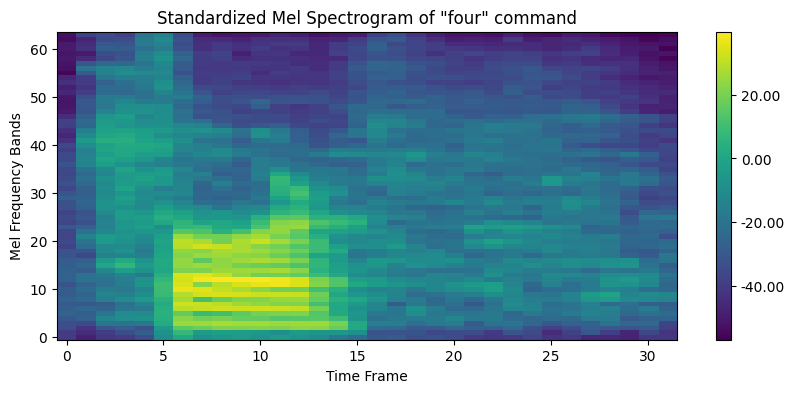

In [14]:
# Let's check a sample from our training data
sample_spec, sample_label_idx, sample_label = next(iter(train_loader))
print(f"Spectrogram batch shape: {sample_spec.shape}")
print(f"Label indices shape: {sample_label_idx.shape}")
print(f"Sample labels: {sample_label[:5]}...")
print(f"Standarized values - Min: {sample_spec.min():.2f}, Max: {sample_spec.max():.2f}, Mean: {sample_spec.mean():.2f}, Std: {sample_spec.std():.2f}")

# Visualize one sample
plt.figure(figsize=(10, 4))
plt.imshow(sample_spec[0][0].numpy(), aspect='auto', origin='lower')
plt.colorbar(format='%.2f')
plt.title(f'Standardized Mel Spectrogram of "{sample_label[0]}" command')
plt.ylabel('Mel Frequency Bands')
plt.xlabel('Time Frame')

In [15]:
class AudioCNN(torch.nn.Module):
    def __init__(self, num_classes, n_mels=64):
        super(AudioCNN, self).__init__()
        
        # First convolutional block
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Second convolutional block
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Third convolutional block
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Fourth convolutional block
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Calculate size after convolutions
        # After 4 max pooling layers with stride 2, dimensions are reduced by a factor of 2^4 = 16
        self.mel_reduced = n_mels // 16
        
        # We don't know the exact width after padding in the collate function,
        # so we'll use adaptive pooling to handle variable widths
        self.adaptive_pool = torch.nn.AdaptiveAvgPool2d((self.mel_reduced, 8))
        
        # Fully connected layers
        self.fc1 = torch.nn.Linear(256 * self.mel_reduced * 8, 512)
        self.fc2 = torch.nn.Linear(512, num_classes)
        
        # Dropout for regularization
        self.dropout = torch.nn.Dropout(0.5)
        
    def forward(self, x):
        # Input x shape: [batch, channels (1), mel_bands, time]
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        # Apply adaptive pooling to get fixed output size
        x = self.adaptive_pool(x)
        
        # Flatten for the fully connected layers
        x = x.view(x.size(0), -1)
        
        # Apply fully connected layers with dropout
        x = self.dropout(torch.nn.functional.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

In [16]:
# Function to predict a single audio file
def predict_audio_file(file_path, model, device, n_mels=64, n_fft=1024, hop_length=512):
    model.eval()
    
    # Load the audio file
    waveform, sample_rate = torchaudio.load(file_path)
    
    # Create transforms
    mel_transform = T.MelSpectrogram(
        sample_rate=16000,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        power=2.0,
    )
    amp_to_db = T.AmplitudeToDB()
    
    # Convert to mel spectrogram
    mel_spec = mel_transform(waveform)
    mel_spec_db = amp_to_db(mel_spec)
    
    # Standardize using training set statistics
    mel_spec_db = (mel_spec_db - train_spectrogram_dataset.spec_mean) / train_spectrogram_dataset.spec_std
    
    # Add batch dimension
    mel_spec_db = mel_spec_db.unsqueeze(0)
    
    # Make prediction
    with torch.no_grad():
        mel_spec_db = mel_spec_db.to(device)
        output = model(mel_spec_db)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        predicted_idx = output.argmax(1).item()
        
    # Get the predicted class and probability
    predicted_class = test_spectrogram_dataset.labels[predicted_idx]
    probability = probabilities[0][predicted_idx].item()
    
    # Get top 3 predictions
    top3_values, top3_indices = torch.topk(probabilities, 3)
    top3_classes = [test_spectrogram_dataset.labels[idx] for idx in top3_indices[0].cpu().numpy()]
    top3_probs = top3_values[0].cpu().numpy()
    
    return {
        'predicted_class': predicted_class,
        'probability': probability,
        'top3_classes': top3_classes,
        'top3_probs': top3_probs,
        'waveform': waveform,
        'mel_spec_db': mel_spec_db[0],
        'sample_rate': sample_rate
    }

In [ ]:
# Train the model

def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001, file_path='training_stats.csv'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    # Lists to store training and validation losses
    train_losses = []
    train_accuracies = []

    val_losses = []
    val_accuracies = []
    
    # Calculate total number of batches
    total_batches = len(train_loader)
    print_interval = max(1, total_batches // 10)  # Print 10 times per epoch
    
    print(f"Training on {device} with {total_batches} batches per epoch")
    print(f"Will print progress every {print_interval} batches ({total_batches//print_interval} times per epoch)")
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Create progress bar for this epoch
        pbar = tqdm(enumerate(train_loader), total=total_batches, 
                     desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
        
        for batch_idx, batch in pbar:
            specs, labels, _ = batch
            specs, labels = specs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(specs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Update statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            batch_correct = (predicted == labels).sum().item()
            correct += batch_correct
            total += labels.size(0)
            
            # Update progress bar with current loss and accuracy
            current_loss = running_loss / (batch_idx + 1)
            current_acc = 100. * correct / total
            pbar.set_postfix({
                'loss': f"{current_loss:.4f}",
                'acc': f"{current_acc:.2f}%"
            })
            
            # Print detailed loss at specified intervals
            if (batch_idx + 1) % print_interval == 0 or (batch_idx + 1) == total_batches:
                print(f"  Batch {batch_idx+1}/{total_batches} - Loss: {current_loss:.4f}, Acc: {current_acc:.2f}%")
        
        # Calculate average loss for this epoch
        avg_train_loss = running_loss / total_batches
        train_losses.append(avg_train_loss)
        train_accuracies.append(correct / total)

        # Validate the model
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        
        print("Validating...")
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc="Validation", leave=True)
            for batch in val_pbar:
                specs, labels, _ = batch
                specs, labels = specs.to(device), labels.to(device)
                
                outputs = model(specs)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item()
                _, predicted = outputs.max(1)
                batch_correct = (predicted == labels).sum().item()
                val_correct += batch_correct
                val_total += labels.size(0)
                
                # Update validation progress bar
                val_pbar.set_postfix({
                    'loss': f"{val_running_loss / (val_pbar.n + 1):.4f}",
                    'acc': f"{100. * val_correct / val_total:.2f}%"
                })
        
        avg_val_loss = val_running_loss / len(val_loader)
        val_accuracy = val_correct / val_total * 100
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Train Acc: {100. * train_accuracies[-1]:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
        print("-" * 80)
    
    dataframe = pd.DataFrame({
        'epoch': range(1, num_epochs + 1),
        'train_loss': train_losses,
        'train_accuracy': train_accuracies,
        'val_loss': val_losses,
        'val_accuracy': val_accuracies,
        #hyperparameters
    })
    dataframe.to_csv(file_path, index=False)
    return train_losses, train_accuracies, val_losses, val_accuracies

In [17]:
model = AudioCNN(num_classes=len(train_spectrogram_dataset.labels))
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model, train_loader, val_loader, num_epochs=10, learning_rate=0.001, file_path='training_stats.csv'
)

Training on cuda with 799 batches per epoch
Will print progress every 79 batches (10 times per epoch)


Epoch 1/10:   0%|          | 0/799 [00:00<?, ?it/s]

  Batch 79/799 - Loss: 3.9025, Acc: 4.13%
  Batch 158/799 - Loss: 3.6122, Acc: 5.35%
  Batch 237/799 - Loss: 3.4471, Acc: 6.82%
  Batch 316/799 - Loss: 3.2915, Acc: 8.92%
  Batch 395/799 - Loss: 3.1561, Acc: 10.99%
  Batch 474/799 - Loss: 3.0331, Acc: 13.20%
  Batch 553/799 - Loss: 2.9203, Acc: 15.49%
  Batch 632/799 - Loss: 2.8194, Acc: 17.45%
  Batch 711/799 - Loss: 2.7341, Acc: 19.24%
  Batch 790/799 - Loss: 2.6592, Acc: 20.84%
  Batch 799/799 - Loss: 2.6516, Acc: 21.01%
Validating...


Validation:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 1/10 - Train Loss: 2.6516, Train Acc: 21.01%, Val Loss: 7.5366, Val Acc: 288.32%
--------------------------------------------------------------------------------


Epoch 2/10:   0%|          | 0/799 [00:00<?, ?it/s]

  Batch 79/799 - Loss: 1.8843, Acc: 37.56%
  Batch 158/799 - Loss: 1.8485, Acc: 38.45%
  Batch 237/799 - Loss: 1.8403, Acc: 38.73%
  Batch 316/799 - Loss: 1.8073, Acc: 39.43%
  Batch 395/799 - Loss: 1.7848, Acc: 39.94%
  Batch 474/799 - Loss: 1.7677, Acc: 40.58%
  Batch 553/799 - Loss: 1.7536, Acc: 40.95%
  Batch 632/799 - Loss: 1.7361, Acc: 41.50%
  Batch 711/799 - Loss: 1.7177, Acc: 42.06%
  Batch 790/799 - Loss: 1.7093, Acc: 42.30%
  Batch 799/799 - Loss: 1.7078, Acc: 42.32%
Validating...


Validation:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 2/10 - Train Loss: 1.7078, Train Acc: 42.32%, Val Loss: 9.7956, Val Acc: 357.46%
--------------------------------------------------------------------------------


Epoch 3/10:   0%|          | 0/799 [00:00<?, ?it/s]

  Batch 79/799 - Loss: 1.5619, Acc: 45.75%
  Batch 158/799 - Loss: 1.5614, Acc: 46.30%
  Batch 237/799 - Loss: 1.5438, Acc: 47.32%
  Batch 316/799 - Loss: 1.5328, Acc: 47.62%
  Batch 395/799 - Loss: 1.5278, Acc: 47.79%
  Batch 474/799 - Loss: 1.5165, Acc: 48.29%
  Batch 553/799 - Loss: 1.5091, Acc: 48.56%
  Batch 632/799 - Loss: 1.5024, Acc: 48.82%
  Batch 711/799 - Loss: 1.5007, Acc: 48.83%
  Batch 790/799 - Loss: 1.4974, Acc: 48.80%
  Batch 799/799 - Loss: 1.4973, Acc: 48.80%
Validating...


Validation:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 3/10 - Train Loss: 1.4973, Train Acc: 48.80%, Val Loss: 11.7431, Val Acc: 114.74%
--------------------------------------------------------------------------------


Epoch 4/10:   0%|          | 0/799 [00:00<?, ?it/s]

  Batch 79/799 - Loss: 1.3867, Acc: 52.02%
  Batch 158/799 - Loss: 1.3974, Acc: 51.16%
  Batch 237/799 - Loss: 1.3927, Acc: 51.09%
  Batch 316/799 - Loss: 1.3874, Acc: 51.42%
  Batch 395/799 - Loss: 1.3802, Acc: 51.70%
  Batch 474/799 - Loss: 1.3739, Acc: 51.93%
  Batch 553/799 - Loss: 1.3705, Acc: 52.07%
  Batch 632/799 - Loss: 1.3661, Acc: 52.35%
  Batch 711/799 - Loss: 1.3653, Acc: 52.41%
  Batch 790/799 - Loss: 1.3630, Acc: 52.43%
  Batch 799/799 - Loss: 1.3637, Acc: 52.40%
Validating...


Validation:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 4/10 - Train Loss: 1.3637, Train Acc: 52.40%, Val Loss: 12.5088, Val Acc: 151.52%
--------------------------------------------------------------------------------


Epoch 5/10:   0%|          | 0/799 [00:00<?, ?it/s]

  Batch 79/799 - Loss: 1.3095, Acc: 53.36%
  Batch 158/799 - Loss: 1.2915, Acc: 54.32%
  Batch 237/799 - Loss: 1.2864, Acc: 54.35%
  Batch 316/799 - Loss: 1.2836, Acc: 54.54%
  Batch 395/799 - Loss: 1.2828, Acc: 54.55%
  Batch 474/799 - Loss: 1.2857, Acc: 54.62%
  Batch 553/799 - Loss: 1.2877, Acc: 54.54%
  Batch 632/799 - Loss: 1.2899, Acc: 54.59%
  Batch 711/799 - Loss: 1.2874, Acc: 54.69%
  Batch 790/799 - Loss: 1.2848, Acc: 54.83%
  Batch 799/799 - Loss: 1.2833, Acc: 54.89%
Validating...


Validation:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 5/10 - Train Loss: 1.2833, Train Acc: 54.89%, Val Loss: 15.3848, Val Acc: 257.43%
--------------------------------------------------------------------------------


Epoch 6/10:   0%|          | 0/799 [00:00<?, ?it/s]

  Batch 79/799 - Loss: 1.1898, Acc: 57.65%
  Batch 158/799 - Loss: 1.1682, Acc: 58.40%
  Batch 237/799 - Loss: 1.1774, Acc: 58.25%
  Batch 316/799 - Loss: 1.1862, Acc: 57.77%
  Batch 395/799 - Loss: 1.1866, Acc: 58.06%
  Batch 474/799 - Loss: 1.1810, Acc: 58.42%
  Batch 553/799 - Loss: 1.1715, Acc: 58.74%
  Batch 632/799 - Loss: 1.1619, Acc: 59.12%
  Batch 711/799 - Loss: 1.1542, Acc: 59.36%
  Batch 790/799 - Loss: 1.1478, Acc: 59.54%
  Batch 799/799 - Loss: 1.1469, Acc: 59.59%
Validating...


Validation:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 6/10 - Train Loss: 1.1469, Train Acc: 59.59%, Val Loss: 17.5455, Val Acc: 330.98%
--------------------------------------------------------------------------------


Epoch 7/10:   0%|          | 0/799 [00:00<?, ?it/s]

  Batch 79/799 - Loss: 1.0583, Acc: 61.85%
  Batch 158/799 - Loss: 1.0570, Acc: 62.11%
  Batch 237/799 - Loss: 1.0692, Acc: 61.91%
  Batch 316/799 - Loss: 1.0671, Acc: 61.85%
  Batch 395/799 - Loss: 1.0674, Acc: 61.91%
  Batch 474/799 - Loss: 1.0668, Acc: 61.91%
  Batch 553/799 - Loss: 1.0686, Acc: 61.92%
  Batch 632/799 - Loss: 1.0699, Acc: 61.99%
  Batch 711/799 - Loss: 1.0632, Acc: 62.24%
  Batch 790/799 - Loss: 1.0587, Acc: 62.46%
  Batch 799/799 - Loss: 1.0575, Acc: 62.49%
Validating...


Validation:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 7/10 - Train Loss: 1.0575, Train Acc: 62.49%, Val Loss: 18.8745, Val Acc: 70.61%
--------------------------------------------------------------------------------


Epoch 8/10:   0%|          | 0/799 [00:00<?, ?it/s]

  Batch 79/799 - Loss: 1.0212, Acc: 63.41%
  Batch 158/799 - Loss: 1.0123, Acc: 63.78%
  Batch 237/799 - Loss: 1.0105, Acc: 63.77%
  Batch 316/799 - Loss: 0.9992, Acc: 64.10%
  Batch 395/799 - Loss: 0.9945, Acc: 64.47%
  Batch 474/799 - Loss: 0.9833, Acc: 64.86%
  Batch 553/799 - Loss: 0.9748, Acc: 65.20%
  Batch 632/799 - Loss: 0.9679, Acc: 65.48%
  Batch 711/799 - Loss: 0.9620, Acc: 65.76%
  Batch 790/799 - Loss: 0.9595, Acc: 65.97%
  Batch 799/799 - Loss: 0.9611, Acc: 65.95%
Validating...


Validation:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 8/10 - Train Loss: 0.9611, Train Acc: 65.95%, Val Loss: 20.4144, Val Acc: 120.62%
--------------------------------------------------------------------------------


Epoch 9/10:   0%|          | 0/799 [00:00<?, ?it/s]

  Batch 79/799 - Loss: 0.8961, Acc: 68.43%
  Batch 158/799 - Loss: 0.8893, Acc: 68.73%
  Batch 237/799 - Loss: 0.8737, Acc: 69.22%
  Batch 316/799 - Loss: 0.8586, Acc: 69.77%
  Batch 395/799 - Loss: 0.8478, Acc: 70.28%
  Batch 474/799 - Loss: 0.8391, Acc: 70.59%
  Batch 553/799 - Loss: 0.8318, Acc: 70.94%
  Batch 632/799 - Loss: 0.8265, Acc: 71.14%
  Batch 711/799 - Loss: 0.8214, Acc: 71.35%
  Batch 790/799 - Loss: 0.8143, Acc: 71.65%
  Batch 799/799 - Loss: 0.8131, Acc: 71.70%
Validating...


Validation:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 9/10 - Train Loss: 0.8131, Train Acc: 71.70%, Val Loss: 22.0791, Val Acc: 98.56%
--------------------------------------------------------------------------------


Epoch 10/10:   0%|          | 0/799 [00:00<?, ?it/s]

  Batch 79/799 - Loss: 0.7284, Acc: 75.28%
  Batch 158/799 - Loss: 0.6963, Acc: 75.99%
  Batch 237/799 - Loss: 0.7019, Acc: 75.68%
  Batch 316/799 - Loss: 0.6851, Acc: 76.28%
  Batch 395/799 - Loss: 0.6770, Acc: 76.63%
  Batch 474/799 - Loss: 0.6740, Acc: 76.77%
  Batch 553/799 - Loss: 0.6724, Acc: 76.91%
  Batch 632/799 - Loss: 0.6748, Acc: 76.87%
  Batch 711/799 - Loss: 0.6725, Acc: 76.96%
  Batch 790/799 - Loss: 0.6666, Acc: 77.17%
  Batch 799/799 - Loss: 0.6664, Acc: 77.16%
Validating...


Validation:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 10/10 - Train Loss: 0.6664, Train Acc: 77.16%, Val Loss: 24.4576, Val Acc: 69.14%
--------------------------------------------------------------------------------


POWYŻSZE VAL_ACC TRZEBA PODZIELIĆ PRZEZ 100

In [18]:
model = AudioCNN(num_classes=len(train_spectrogram_dataset.labels))
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model, train_loader, val_loader, num_epochs=5, learning_rate=1e-5, file_path='training_stats_2.csv'
)

Training on cuda with 799 batches per epoch
Will print progress every 79 batches (10 times per epoch)


Epoch 1/5:   0%|          | 0/799 [00:00<?, ?it/s]

  Batch 79/799 - Loss: 3.3988, Acc: 5.30%
  Batch 158/799 - Loss: 3.3488, Acc: 7.28%
  Batch 237/799 - Loss: 3.2965, Acc: 9.11%
  Batch 316/799 - Loss: 3.2404, Acc: 10.95%
  Batch 395/799 - Loss: 3.1834, Acc: 12.58%
  Batch 474/799 - Loss: 3.1261, Acc: 14.24%
  Batch 553/799 - Loss: 3.0648, Acc: 15.96%
  Batch 632/799 - Loss: 3.0034, Acc: 17.60%
  Batch 711/799 - Loss: 2.9407, Acc: 19.26%
  Batch 790/799 - Loss: 2.8803, Acc: 20.85%
  Batch 799/799 - Loss: 2.8734, Acc: 21.02%
Validating...


Validation:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 1/5 - Train Loss: 2.8734, Train Acc: 21.02%, Val Loss: 3.9111, Val Acc: 361.87%
--------------------------------------------------------------------------------


Epoch 2/5:   0%|          | 0/799 [00:00<?, ?it/s]

  Batch 79/799 - Loss: 2.2241, Acc: 39.44%
  Batch 158/799 - Loss: 2.1711, Acc: 40.25%
  Batch 237/799 - Loss: 2.1148, Acc: 41.69%
  Batch 316/799 - Loss: 2.0673, Acc: 43.25%
  Batch 395/799 - Loss: 2.0250, Acc: 44.28%
  Batch 474/799 - Loss: 1.9779, Acc: 45.69%
  Batch 553/799 - Loss: 1.9403, Acc: 46.74%
  Batch 632/799 - Loss: 1.9024, Acc: 47.72%
  Batch 711/799 - Loss: 1.8648, Acc: 48.79%
  Batch 790/799 - Loss: 1.8328, Acc: 49.77%
  Batch 799/799 - Loss: 1.8285, Acc: 49.89%
Validating...


Validation:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 2/5 - Train Loss: 1.8285, Train Acc: 49.89%, Val Loss: 4.9400, Val Acc: 189.76%
--------------------------------------------------------------------------------


Epoch 3/5:   0%|          | 0/799 [00:00<?, ?it/s]

  Batch 79/799 - Loss: 1.4085, Acc: 61.79%
  Batch 158/799 - Loss: 1.4046, Acc: 61.83%
  Batch 237/799 - Loss: 1.3706, Acc: 62.76%
  Batch 316/799 - Loss: 1.3531, Acc: 63.22%
  Batch 395/799 - Loss: 1.3276, Acc: 63.88%
  Batch 474/799 - Loss: 1.3068, Acc: 64.44%
  Batch 553/799 - Loss: 1.2880, Acc: 64.91%
  Batch 632/799 - Loss: 1.2652, Acc: 65.57%
  Batch 711/799 - Loss: 1.2494, Acc: 65.95%
  Batch 790/799 - Loss: 1.2264, Acc: 66.66%
  Batch 799/799 - Loss: 1.2235, Acc: 66.72%
Validating...


Validation:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 3/5 - Train Loss: 1.2235, Train Acc: 66.72%, Val Loss: 5.9231, Val Acc: 104.44%
--------------------------------------------------------------------------------


Epoch 4/5:   0%|          | 0/799 [00:00<?, ?it/s]

  Batch 79/799 - Loss: 1.0497, Acc: 71.84%
  Batch 158/799 - Loss: 1.0071, Acc: 73.02%
  Batch 237/799 - Loss: 1.0018, Acc: 73.21%
  Batch 316/799 - Loss: 0.9854, Acc: 73.54%
  Batch 395/799 - Loss: 0.9634, Acc: 74.09%
  Batch 474/799 - Loss: 0.9477, Acc: 74.50%
  Batch 553/799 - Loss: 0.9388, Acc: 74.63%
  Batch 632/799 - Loss: 0.9262, Acc: 74.99%
  Batch 711/799 - Loss: 0.9174, Acc: 75.18%
  Batch 790/799 - Loss: 0.9070, Acc: 75.43%
  Batch 799/799 - Loss: 0.9061, Acc: 75.44%
Validating...


Validation:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 4/5 - Train Loss: 0.9061, Train Acc: 75.44%, Val Loss: 6.7606, Val Acc: 117.68%
--------------------------------------------------------------------------------


Epoch 5/5:   0%|          | 0/799 [00:00<?, ?it/s]

  Batch 79/799 - Loss: 0.7512, Acc: 79.29%
  Batch 158/799 - Loss: 0.7941, Acc: 78.43%
  Batch 237/799 - Loss: 0.7784, Acc: 78.60%
  Batch 316/799 - Loss: 0.7670, Acc: 79.12%
  Batch 395/799 - Loss: 0.7702, Acc: 78.90%
  Batch 474/799 - Loss: 0.7637, Acc: 79.05%
  Batch 553/799 - Loss: 0.7603, Acc: 79.25%
  Batch 632/799 - Loss: 0.7473, Acc: 79.57%
  Batch 711/799 - Loss: 0.7403, Acc: 79.77%
  Batch 790/799 - Loss: 0.7306, Acc: 79.99%
  Batch 799/799 - Loss: 0.7306, Acc: 79.98%
Validating...


Validation:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 5/5 - Train Loss: 0.7306, Train Acc: 79.98%, Val Loss: 7.3568, Val Acc: 105.91%
--------------------------------------------------------------------------------


# Standarize data

In [19]:
train_spectrogram_dataset = SpeechCommandsSpectrogramDataset(all_data['training'], standardize=True)
val_spectrogram_dataset = SpeechCommandsSpectrogramDataset(all_data['validation'], standardize=False)
test_spectrogram_dataset = SpeechCommandsSpectrogramDataset(all_data['testing'], standardize=False)

# Apply the training set statistics to validation and test sets
val_spectrogram_dataset.standardize = True
val_spectrogram_dataset.spec_mean = train_spectrogram_dataset.spec_mean
val_spectrogram_dataset.spec_std = train_spectrogram_dataset.spec_std

test_spectrogram_dataset.standardize = True
test_spectrogram_dataset.spec_mean = train_spectrogram_dataset.spec_mean
test_spectrogram_dataset.spec_std = train_spectrogram_dataset.spec_std


# Function for padding spectrograms in a batch (they might have different lengths)
def collate_spectrograms(batch):
    # Unpack all 4 values but only use the first 3
    specs, label_ids, labels = zip(*batch)
    
    # Find max width (time dimension)
    max_width = max(spec.shape[2] for spec in specs)
    
    # Pad all spectrograms to the same width
    padded_specs = []
    for spec in specs:
        # Calculate padding needed
        pad_amount = max_width - spec.shape[2]
        # Pad the time dimension (right side only)
        padded_spec = F.pad(spec, (0, pad_amount))
        padded_specs.append(padded_spec)
    
    # Stack into tensors
    specs_tensor = torch.stack(padded_specs)
    labels_tensor = torch.tensor(label_ids)
    
    return specs_tensor, labels_tensor, labels

# Create DataLoaders with our collate function
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_spectrogram_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    collate_fn=collate_spectrograms,
)

val_loader = torch.utils.data.DataLoader(
    val_spectrogram_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=collate_spectrograms,
)

test_loader = torch.utils.data.DataLoader(
    test_spectrogram_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=collate_spectrograms,
)

Computing dataset statistics on 500 samples...
Dataset statistics - Mean: -23.02, Std: 20.93
Found 31 unique classes: ['_background_noise_', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']
Found 30 unique classes: ['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']
Found 30 unique classes: ['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']


In [20]:
model = AudioCNN(num_classes=len(train_spectrogram_dataset.labels))
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model, train_loader, val_loader, num_epochs=5, learning_rate=1e-5, file_path='training_stats_3.csv'
)

Training on cuda with 799 batches per epoch
Will print progress every 79 batches (10 times per epoch)


Epoch 1/5:   0%|          | 0/799 [00:00<?, ?it/s]

  Batch 79/799 - Loss: 3.4162, Acc: 4.94%
  Batch 158/799 - Loss: 3.3726, Acc: 6.10%
  Batch 237/799 - Loss: 3.3337, Acc: 7.54%
  Batch 316/799 - Loss: 3.2901, Acc: 9.19%
  Batch 395/799 - Loss: 3.2388, Acc: 10.85%
  Batch 474/799 - Loss: 3.1880, Acc: 12.33%
  Batch 553/799 - Loss: 3.1308, Acc: 14.05%
  Batch 632/799 - Loss: 3.0707, Acc: 15.93%
  Batch 711/799 - Loss: 3.0097, Acc: 17.63%
  Batch 790/799 - Loss: 2.9480, Acc: 19.32%
  Batch 799/799 - Loss: 2.9413, Acc: 19.46%
Validating...


Validation:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 1/5 - Train Loss: 2.9413, Train Acc: 19.46%, Val Loss: 3.8775, Val Acc: 341.28%
--------------------------------------------------------------------------------


Epoch 2/5:   0%|          | 0/799 [00:00<?, ?it/s]

  Batch 79/799 - Loss: 2.2627, Acc: 38.73%
  Batch 158/799 - Loss: 2.2070, Acc: 40.27%
  Batch 237/799 - Loss: 2.1505, Acc: 41.88%
  Batch 316/799 - Loss: 2.1023, Acc: 43.14%
  Batch 395/799 - Loss: 2.0528, Acc: 44.55%
  Batch 474/799 - Loss: 2.0039, Acc: 45.92%
  Batch 553/799 - Loss: 1.9579, Acc: 47.17%
  Batch 632/799 - Loss: 1.9125, Acc: 48.32%
  Batch 711/799 - Loss: 1.8715, Acc: 49.47%
  Batch 790/799 - Loss: 1.8296, Acc: 50.71%
  Batch 799/799 - Loss: 1.8247, Acc: 50.83%
Validating...


Validation:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 2/5 - Train Loss: 1.8247, Train Acc: 50.83%, Val Loss: 4.9814, Val Acc: 163.28%
--------------------------------------------------------------------------------


Epoch 3/5:   0%|          | 0/799 [00:00<?, ?it/s]

  Batch 79/799 - Loss: 1.3839, Acc: 62.60%
  Batch 158/799 - Loss: 1.3441, Acc: 64.21%
  Batch 237/799 - Loss: 1.3236, Acc: 64.58%
  Batch 316/799 - Loss: 1.3062, Acc: 65.08%
  Batch 395/799 - Loss: 1.2803, Acc: 65.74%
  Batch 474/799 - Loss: 1.2515, Acc: 66.56%
  Batch 553/799 - Loss: 1.2308, Acc: 67.10%
  Batch 632/799 - Loss: 1.2065, Acc: 67.78%
  Batch 711/799 - Loss: 1.1935, Acc: 68.15%
  Batch 790/799 - Loss: 1.1719, Acc: 68.70%
  Batch 799/799 - Loss: 1.1701, Acc: 68.73%
Validating...


Validation:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 3/5 - Train Loss: 1.1701, Train Acc: 68.73%, Val Loss: 6.0618, Val Acc: 114.74%
--------------------------------------------------------------------------------


Epoch 4/5:   0%|          | 0/799 [00:00<?, ?it/s]

  Batch 79/799 - Loss: 0.9642, Acc: 74.51%
  Batch 158/799 - Loss: 0.9417, Acc: 75.03%
  Batch 237/799 - Loss: 0.9323, Acc: 75.20%
  Batch 316/799 - Loss: 0.9240, Acc: 75.35%
  Batch 395/799 - Loss: 0.9102, Acc: 75.74%
  Batch 474/799 - Loss: 0.9067, Acc: 75.83%
  Batch 553/799 - Loss: 0.8942, Acc: 76.13%
  Batch 632/799 - Loss: 0.8782, Acc: 76.51%
  Batch 711/799 - Loss: 0.8703, Acc: 76.62%
  Batch 790/799 - Loss: 0.8589, Acc: 76.96%
  Batch 799/799 - Loss: 0.8573, Acc: 77.00%
Validating...


Validation:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 4/5 - Train Loss: 0.8573, Train Acc: 77.00%, Val Loss: 6.9500, Val Acc: 107.38%
--------------------------------------------------------------------------------


Epoch 5/5:   0%|          | 0/799 [00:00<?, ?it/s]

  Batch 79/799 - Loss: 0.7642, Acc: 79.57%
  Batch 158/799 - Loss: 0.7371, Acc: 80.32%
  Batch 237/799 - Loss: 0.7367, Acc: 80.51%
  Batch 316/799 - Loss: 0.7359, Acc: 80.53%
  Batch 395/799 - Loss: 0.7314, Acc: 80.44%
  Batch 474/799 - Loss: 0.7258, Acc: 80.47%
  Batch 553/799 - Loss: 0.7157, Acc: 80.72%
  Batch 632/799 - Loss: 0.7058, Acc: 80.99%
  Batch 711/799 - Loss: 0.7016, Acc: 81.07%
  Batch 790/799 - Loss: 0.6993, Acc: 81.11%
  Batch 799/799 - Loss: 0.6986, Acc: 81.15%
Validating...


Validation:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 5/5 - Train Loss: 0.6986, Train Acc: 81.15%, Val Loss: 7.6359, Val Acc: 120.62%
--------------------------------------------------------------------------------
